In [1]:
import numpy as np
import os 
import pandas as pd 
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from tqdm import tqdm
import time
import datetime
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss
import torchvision
from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt

drive.mount('/content/drive')
path = '/content/drive/My Drive/zindi_invertebrates/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### tfms helps to do data augmentation on the data to have a better pixel values

In [2]:
seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
#transormation of dataset
tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.3,max_zoom=1.4,max_rotate=45)

In [ ]:
data = ImageDataBunch.from_folder(path, train="train", test='test', size=224,valid_pct=0.10, 
                                  ds_tfms=tfms,num_workers=2,seed=seed,bs=64,device='cuda').normalize(imagenet_stats)

In [5]:
len(data.valid_ds)

348

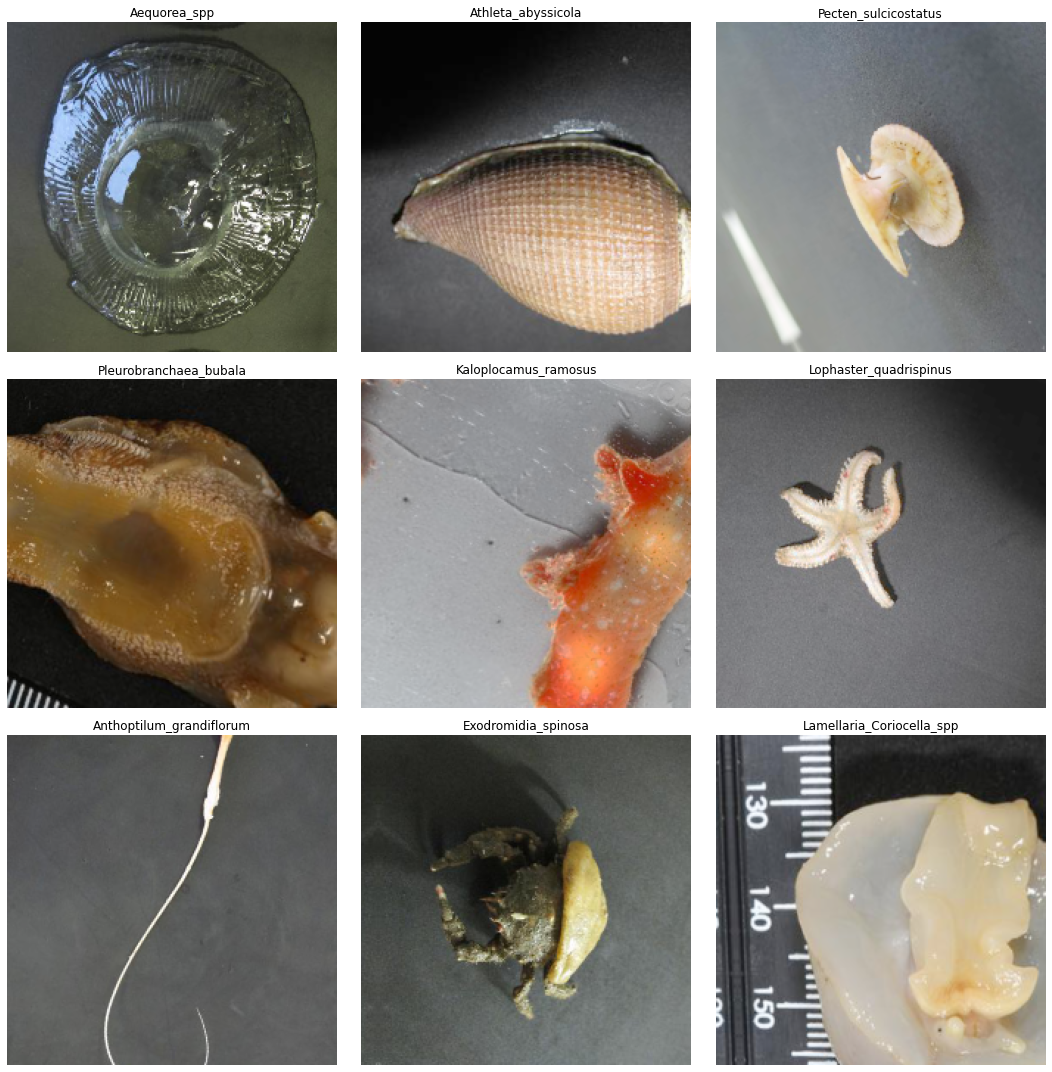

In [ ]:
data.show_batch(rows=3, figsize=(15, 15)) 

### Create a baseline model using resnet18

In [6]:
#download pretrained resnet18
model_conv = torchvision.models.resnet34
learn = cnn_learner(data, model_conv, loss_func=CrossEntropyLoss(), metrics=[error_rate, accuracy], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
# Fit
num_epochs = 35
learn.fit_one_cycle(num_epochs, 0.009)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.436492,3.183216,0.729885,0.270115,00:50
1,3.743239,1.613821,0.433908,0.566092,00:48
2,2.443130,0.822454,0.218391,0.781609,00:48
3,1.645058,0.617764,0.163793,0.836207,00:48
4,1.193587,0.526455,0.140805,0.859195,00:48
5,1.071749,0.562405,0.201149,0.798851,00:48
6,1.066415,0.848654,0.212644,0.787356,00:48
7,1.099505,0.998968,0.270115,0.729885,00:49
8,1.206795,1.024416,0.250000,0.750000,00:48
9,1.210168,0.885191,0.229885,0.770115,00:49


In [ ]:
#get predictions
preds_test, y_test = learn.get_preds(DatasetType.Test)

In [9]:
#submit
sub=pd.read_csv(path+'SampleSubmission.csv')
k=sub.columns.tolist()
submission = pd.DataFrame({'FILE': [s for s in os.listdir(path+'test')]})

for i, c in enumerate(learn.data.classes):
    submission[c] = preds_test[:,i]

submission = submission[k]
submission.to_csv('sub.csv', index=False)
files.download("sub.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
submission.head()

,FILE,Pteraster_capensis,Porifera,Astropecten_irregularis_pontoporeus,Terebratulina_sp_,Neolithodes_asperrimus,Munida_benguela,Cypraeovula_iutsui,Kaloplocamus_ramosus,Actinoscyphia_plebeia,Echinus_gilchristi,Synallactes_viridilimus,Eleutherobia_variable,Neopilumnoplax_heterochir,Pleurobranchaea_bubala,Pagurus_cuanensis,Parapagurus_bouvieri,Inachidae,Pseudarchaster_tessellatus,Pasiphaea_sp._1,Suberites_dandelenae,Comitas_saldanhae,Poraniopsis_echinaster,Pterygosquilla_capensis,Holothuroidea,Exodromidia_spinosa,Aristeus_varidens,Philinopsis_capensis,Vitjazmaia_latidactyla,Perissasterias_polyacantha,Ascidiacea,Toraster_tuberculatus,Nudibranchia,Mediaster_bairdi_capensis,Limopsis_chuni,Comitas_stolida,Psilaster_acuminatus,Lithodes_ferox,Hermit_crab,Solenocera_africana,...,Ophiura_costata_costata,Pelagia_noctiluca,Sclerasterias_spp,Stylasteridae,Fusivoluta_pyrrhostoma,Actinoptilum_molle,Pseudarchaster_brachyactis,Nassarius speciosus,Chondraster_elattosis,Ophiothrix_aristulata,Aphelodoris_sp_,Fusinus_africanae,Scaphander_punctostriatus,Polychaete_tubes_(only),Polychaete_worms,Polyechinus_agulhensis,Chrysaora_spp,Projasus_parkeri,Lamellaria_Coriocella_spp,Hippasteria_phrygiana,Mursia_cristiata,Prawns,Nassarius_vinctus,Marthasterias_africana,Goneplax_clevai,Alcyonacea,Athleta_lutosa,Pseudodromia_spp_,Rochinia_hertwigi,Africolaria_rutila,Neptuneopsis_gilchristi,Pseudodromia_rotunda,Pecten_sulcicostatus,Plesionika_martia,Rossella_antarctica,Philine_aperta,Mycale_anisochela,Henricia_abyssalis,Triviella_spp_,Cheilostomatida
0,T9LH0MS.jpeg,3.582902e-13,4.835504e-13,8.120114e-08,4.987829e-13,1.907884e-09,2.018155e-06,1.896720e-12,2.175177e-08,5.542667e-08,4.171197e-11,1.683018e-08,1.897098e-10,2.946307e-11,1.367607e-10,6.537403e-11,1.667227e-10,3.820899e-11,1.816510e-08,1.315608e-07,1.384844e-11,2.947207e-10,1.240026e-09,4.437092e-07,1.405370e-11,4.881304e-11,5.613865e-05,8.314376e-11,2.330098e-11,7.076931e-14,3.194075e-12,5.491808e-12,7.748916e-08,6.073097e-11,1.554146e-13,1.739921e-08,6.625107e-11,7.408552e-08,4.722364e-09,1.343184e-05,...,5.442750e-10,7.458833e-07,2.879275e-11,8.134188e-08,8.309430e-11,2.033039e-10,6.719495e-12,8.506904e-11,3.867534e-10,1.810710e-07,2.916548e-07,1.290242e-12,8.479624e-11,3.134707e-11,1.682738e-07,1.939350e-11,8.766197e-12,1.915472e-08,2.124126e-14,4.529534e-12,5.698711e-10,9.935163e-01,6.517992e-11,3.861022e-12,1.238560e-09,6.054320e-09,5.388934e-09,3.107122e-11,1.424597e-11,4.104310e-12,4.152582e-11,1.454415e-12,4.075486e-12,1.271354e-07,1.838725e-09,7.283172e-11,6.033952e-12,5.905305e-12,1.839051e-13,5.810792e-12
1,H5BALID.jpeg,2.088973e-11,1.981747e-10,4.274693e-07,5.981088e-10,5.843336e-07,6.737902e-03,1.720845e-07,2.967801e-07,5.590366e-09,4.656980e-08,4.006724e-09,1.508812e-08,4.295890e-06,7.794351e-11,8.266045e-09,7.510897e-05,5.396641e-06,7.830240e-09,2.211968e-07,1.426904e-09,3.799977e-10,1.085468e-07,5.006062e-03,4.862760e-09,2.248325e-11,2.118958e-03,4.156111e-09,1.410574e-08,3.768511e-08,9.695051e-10,2.367294e-10,9.077505e-09,1.756630e-08,1.757741e-10,8.960389e-10,1.272821e-09,2.205674e-05,4.018170e-07,4.563695e-03,...,4.381696e-06,3.615330e-09,4.109122e-07,7.230881e-10,3.138283e-08,4.017976e-08,2.501659e-09,2.529412e-08,3.751961e-10,3.473260e-05,1.193313e-08,2.413467e-08,1.271873e-08,1.663007e-07,3.187138e-04,1.204180e-07,2.395457e-08,9.776692e-01,6.528268e-11,1.958869e-09,3.144428e-09,2.174815e-03,2.257262e-08,4.436808e-07,9.839608e-08,1.519938e-08,5.835873e-11,2.844099e-09,2.748746e-07,2.294111e-09,7.717078e-10,1.294167e-10,1.111868e-09,1.979907e-06,1.373238e-09,1.790172e-09,1.224488e-08,2.192571e-08,4.984911e-08,4.941316e-09
2,DU8PYE7.jpeg,2.725041e-13,5.510072e-12,1.007932e-08,8.441270e-13,1.155398e-04,9.916324e-08,6.079665e-11,2.203916e-08,2.337427e-08,8.467660e-11,1.566383e-08,3.395470e-10,1.452025e-09,1.056070e-11,3.361974e-09,1.819671e-09,1.308571e-10,3.887305e-08,7.891542e-10,6.254251e-09,1.536996e-11,4.200406e-08,9.969101e-08,4.717102e-10,1.245071e-12,3.296152e-03,1.500695e-11,1.05